## 0. Libarary 불러오기

In [69]:
import os, glob
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.models import resnet50, resnext50_32x4d, resnet18, resnext101_32x8d
import timm
import albumentations as A

from torchsummary import summary
import torch_optimizer as optim
from torchsampler import ImbalancedDatasetSampler
from catalyst.data import BalanceClassSampler

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline 

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


## 1. 데이터셋 정의

### (1) Train Dataset

In [4]:
# 학습 데이터셋 폴더 경로를 지정해주세요.
train_dir = '/opt/ml/input/data/train'
trainimage_dir = os.path.join(train_dir, 'images')

In [5]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [6]:
masks = ['mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'incorrect_mask', 'normal']
wears = ['Wear', 'Wear', 'Wear', 'Wear', 'Wear', 'Incorrect', 'Not Wear']
mask_df = pd.DataFrame()
for person in train_df.values:
    for mask, wear in zip(masks, wears):
        mask_df = mask_df.append(pd.Series(np.append(person, (mask, wear))), ignore_index=True)
mask_df.columns = np.append(train_df.columns.values, ('mask', 'wear'))
mask_df

,id,gender,race,age,path,mask,wear
0,000001,female,Asian,45.0,000001_female_Asian_45,mask1,Wear
1,000001,female,Asian,45.0,000001_female_Asian_45,mask2,Wear
2,000001,female,Asian,45.0,000001_female_Asian_45,mask3,Wear
3,000001,female,Asian,45.0,000001_female_Asian_45,mask4,Wear
4,000001,female,Asian,45.0,000001_female_Asian_45,mask5,Wear
...,...,...,...,...,...,...,...
18895,006959,male,Asian,19.0,006959_male_Asian_19,mask3,Wear
18896,006959,male,Asian,19.0,006959_male_Asian_19,mask4,Wear
18897,006959,male,Asian,19.0,006959_male_Asian_19,mask5,Wear
18898,006959,male,Asian,19.0,006959_male_Asian_19,incorrect_mask,Incorrect


In [7]:
mask_df = mask_df.sample(frac=1).reset_index(drop=True)
mask_df

,id,gender,race,age,path,mask,wear
0,003038,female,Asian,20.0,003038_female_Asian_20,incorrect_mask,Incorrect
1,001076,male,Asian,48.0,001076_male_Asian_48,incorrect_mask,Incorrect
2,003510,male,Asian,58.0,003510_male_Asian_58,incorrect_mask,Incorrect
3,004373,male,Asian,60.0,004373_male_Asian_60,mask2,Wear
4,005138,male,Asian,30.0,005138_male_Asian_30,mask5,Wear
...,...,...,...,...,...,...,...
18895,000006,female,Asian,59.0,000006_female_Asian_59,mask5,Wear
18896,001021,female,Asian,58.0,001021_female_Asian_58,mask1,Wear
18897,001031,female,Asian,45.0,001031_female_Asian_45,normal,Not Wear
18898,003762,female,Asian,44.0,003762_female_Asian_44,mask5,Wear


In [60]:
labeled_df = pd.DataFrame()
for idx, person in mask_df.iterrows():
    gender = person['gender']
    gender = 0 if gender=='male' else 1

    age = person['age']
    if age >= 60.0:
        age = 2
    elif age >= 30.0:
        age = 1
    else:
        age = 0

    mask = person['wear']
    if mask == 'Wear':
        mask = 0
    elif mask == 'Incorrect':
        mask = 1
    else:
        mask = 2

    label = 6*mask + 3*gender + age
    labeled_df = labeled_df.append(pd.Series(np.append(person, label)), ignore_index=True)
labeled_df.columns = np.append(mask_df.columns.values, 'label')
labeled_df = labeled_df.astype({'label': int})
labeled_df

,id,gender,race,age,path,mask,wear,label
0,003038,female,Asian,20.0,003038_female_Asian_20,incorrect_mask,Incorrect,9.0
1,001076,male,Asian,48.0,001076_male_Asian_48,incorrect_mask,Incorrect,7.0
2,003510,male,Asian,58.0,003510_male_Asian_58,incorrect_mask,Incorrect,7.0
3,004373,male,Asian,60.0,004373_male_Asian_60,mask2,Wear,2.0
4,005138,male,Asian,30.0,005138_male_Asian_30,mask5,Wear,1.0
...,...,...,...,...,...,...,...,...
18895,000006,female,Asian,59.0,000006_female_Asian_59,mask5,Wear,4.0
18896,001021,female,Asian,58.0,001021_female_Asian_58,mask1,Wear,4.0
18897,001031,female,Asian,45.0,001031_female_Asian_45,normal,Not Wear,16.0
18898,003762,female,Asian,44.0,003762_female_Asian_44,mask5,Wear,4.0


In [62]:
train, valid = train_test_split(labeled_df, test_size=0.2, stratify=labeled_df['label'])
print(f'Train Set dim : (%d, %d)' % (train.shape))
print(f'Valid Set dim : (%d, %d)' % (valid.shape))

Train Set dim : (15120, 8)
Valid Set dim : (3780, 8)


In [134]:
#transform = transforms.Compose([
#    Resize((224, 224), Image.BILINEAR),
#    ToTensor(),
#    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
#])

transform = transforms.Compose([
    transforms.CenterCrop(224),
    #transforms.Resize((224, 224), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#transform = A.Compose([
#    A.CenterCrop(224, 224),
#    A.HorizontalFlip(p=0.5),
#    A.RandomBrightnessContrast(p=0.2),
#    A.pytorch.transforms.ToTensor({'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}),
#])

In [95]:
class TrainDataset(Dataset):
    def __init__(self, path, labeled_df, transform):
        super(TrainDataset).__init__()
        self.path = path
        self.labeled_df = labeled_df
        self.transform = transform
        
    def __getitem__(self, idx):
        full_path = os.path.join(self.path, self.labeled_df.iloc[idx]['path'])
        img_list = glob.glob(full_path + '/*')
        file_name = self.labeled_df.iloc[idx]['mask']
        try:
            image = Image.open(os.path.join(full_path, file_name+'.jpg'))
        except:
            try:
                image = Image.open(os.path.join(full_path, file_name+'.png'))
            except:
                image = Image.open(os.path.join(full_path, file_name+'.jpeg'))
        if self.transform:
            image = self.transform(image)
        label = self.labeled_df.iloc[idx]['label']
        return image, label
    
    def __len__(self):
        return len(self.labeled_df)
    
    def get_labels(self):
        return self.labeled_df['label']

In [96]:
train_data = TrainDataset(trainimage_dir, train, transform)
valid_data = TrainDataset(trainimage_dir, valid, transform)

In [97]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=4, sampler=ImbalancedDatasetSampler(train_data))
valid_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=4, shuffle=True)

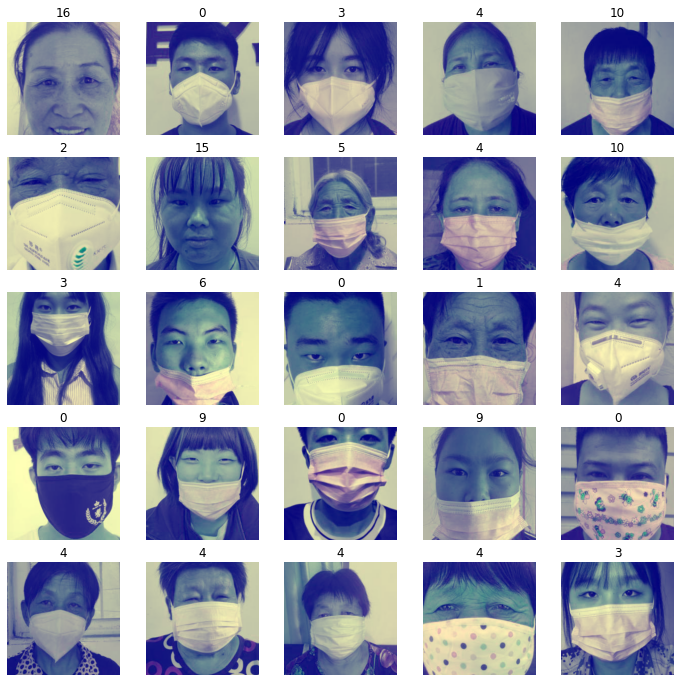

In [100]:
columns = 5
rows = 5
fig = plt.figure(figsize=(12,12))

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#for i, (images, targets) in enumerate(train_loader) :
for i in range(1, columns*rows+1):
    #print(i)
    data_idx = np.random.randint(len(train_loader))
    #input_img = mask_train.dataset[data_idx][0].unsqueeze(dim=0).to(device)
    #print(input_img.shape)
    label = train_loader.dataset[data_idx][1]
    
    labels_map = {0:'Wear', 1:'Incorrect', 2:'Not Wear'}
    fig.add_subplot(rows, columns, i)
    pred_title = label
    plt.title(pred_title)
    
    plot_img = train_loader.dataset[data_idx][0]
    #print(plot_img.shape)
    # 이미지를 normalization 이전 상태로 되돌리는 작업
    plot_img[0, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    #plot_img = plot_img[:, 24:200, 24:200]
    plot_img = transforms.functional.to_pil_image(plot_img)
    #print(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
#plt.show()

### (2) Test Dataset

In [135]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        super(TestDataset).__init__()
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [136]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [137]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
testimage_dir = os.path.join(test_dir, 'images')

In [138]:
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(testimage_dir, img_id) for img_id in submission.ImageID]
#transform = transforms.Compose([
#    Resize((224, 224), Image.BILINEAR),
#    ToTensor(),
#    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
#])
test_dataset = TestDataset(image_paths, transform)

test_loader = DataLoader(
    test_dataset,
    shuffle=False
)

## 2. Model

In [107]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [117]:
class MyModel(nn.Module):
    def __init__(self, model, fc_name: str = 'fc', num_classes: int = 1000):
        super(MyModel, self).__init__()
        self.model = model
        if fc_name == 'fc':
            in_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif fc_name == 'classifier':
            in_features = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
        elif fc_name == 'classif':
            in_features = self.model.classif.in_features
            self.model.classif = nn.Identity()
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc(self.model(x))
        return x

In [118]:
model = MyModel(timm.create_model('inception_resnet_v2', pretrained=True), 'classif', num_classes=18)
#for param in model.parameters():
#    param.requires_grad = False # frozen
#for param in model.fc.parameters():
#    param.requires_grad = True # 마지막 레이어 살리기
torch.nn.init.xavier_uniform_(model.fc.weight)
stdv=1/np.sqrt(1536)
model.fc.bias.data.uniform_(-stdv, stdv)
model.to(device)

MyModel(
  (model): InceptionResnetV2(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_

## 3. Training

In [119]:
learning_rate = 0.0015
betas = (0.9, 0.999)
weight_decay = 1e-4
T_max = 50

In [120]:
optimizer = optim.RAdam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max)

num_epochs = 30

valid_early_stop = 0
valid_best_loss = float('inf')
EARLY_STOPPING_EPOCH = 5
since = time.time()

final_train_loss = []
final_train_acc = []
final_valid_loss = []
final_valid_acc = []

for e in range(num_epochs) :
    print(f' ====================== epoch %d ======================' % (e+1) )
    train_loss_list = []
    train_acc_list = []
    epoch_f1 = 0
    n_iter = 0

    # train
    model.train()
    for i, (images, targets) in enumerate(train_loader) : 
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        scores = model(images)
        _, preds = scores.max(dim=1)

        loss = F.cross_entropy(scores, targets)
        loss.backward()
        optimizer.step()

        correct = sum(targets == preds).cpu()
        acc=(correct/images.shape[0] * 100)
        epoch_f1 += f1_score(preds.cpu().numpy(), targets.cpu().numpy(), average='macro')
        n_iter += 1

        train_loss_list.append(loss)
        train_acc_list.append(acc)

        if i % 50 == 0 :
            print(f'Iteration %3.d | Train Loss  %.4f | Classifier Accuracy %2.2f' % (i, loss, acc))

    train_mean_loss = np.mean(train_loss_list, dtype="float64")
    train_mean_acc = np.mean(train_acc_list, dtype="float64")

    final_train_loss.append(train_mean_loss)
    final_train_acc.append(train_mean_acc)
    
    epoch_f1 = epoch_f1/n_iter

    epoch_time = time.time() - since
    since = time.time()

    print('')
    print(f'[Summary] Elapsed time : %.0f m %.0f s' % (epoch_time // 60, epoch_time % 60))
    print(f'Train Loss Mean %.4f | Accuracy %2.2f | F1-Score %2.4f' % (train_mean_loss, train_mean_acc, epoch_f1) )

    # validation 
    model.eval()
    epoch_f1 = 0
    n_iter = 0
    valid_loss_list = []
    valid_acc_list = []
    for i, (images, targets) in enumerate(valid_loader) : 
        optimizer.zero_grad()
        images = images.to(device=device)
        targets = targets.to(device=device)

        with torch.no_grad():
            scores = model(images)
            loss = F.cross_entropy(scores, targets)
            _, preds = scores.max(dim=1)
            epoch_f1 += f1_score(preds.cpu().numpy(), targets.cpu().numpy(), average='macro')
            n_iter += 1

        correct = sum(targets == preds).cpu()
        acc=(correct/images.shape[0] * 100)

        valid_loss_list.append(loss)
        valid_acc_list.append(acc)

    val_mean_loss = np.mean(valid_loss_list, dtype="float64")
    val_mean_acc = np.mean(valid_acc_list, dtype="float64")

    final_valid_loss.append(val_mean_loss)
    final_valid_acc.append(val_mean_acc)
    
    epoch_f1 = epoch_f1/n_iter
    
    print(f'Valid Loss Mean %.4f | Accuracy %2.2f | F1-Score %2.4f' % (val_mean_loss, val_mean_acc, epoch_f1) )
    print('')

    if val_mean_loss < valid_best_loss:
        valid_best_loss = val_mean_loss
        valid_early_stop = 0
        # new best model save (valid 기준)
        best_model = model
        path = './model/'
        torch.save(best_model.state_dict(), f'{path}model{val_mean_acc:2.2f}_epoch_{e}.pth')
    else:
        # early stopping    
        valid_early_stop += 1
        if valid_early_stop >= EARLY_STOPPING_EPOCH:
            print("EARLY STOPPING!!")
            break

    lr_sched.step()

 ====================== epoch 1 ======================
Iteration   0 | Train Loss  2.9361 | Classifier Accuracy 6.25
Iteration  50 | Train Loss  0.8595 | Classifier Accuracy 65.62
Iteration 100 | Train Loss  0.6707 | Classifier Accuracy 68.75
Iteration 150 | Train Loss  0.4865 | Classifier Accuracy 84.38
Iteration 200 | Train Loss  0.3436 | Classifier Accuracy 84.38
Iteration 250 | Train Loss  0.8713 | Classifier Accuracy 68.75
Iteration 300 | Train Loss  0.2339 | Classifier Accuracy 90.62
Iteration 350 | Train Loss  0.3199 | Classifier Accuracy 84.38
Iteration 400 | Train Loss  0.3549 | Classifier Accuracy 90.62
Iteration 450 | Train Loss  0.2596 | Classifier Accuracy 90.62

[Summary] Elapsed time : 3 m 11 s
Train Loss Mean 0.5581 | Accuracy 81.50 | F1-Score 0.7615
Valid Loss Mean 0.3804 | Accuracy 87.55 | F1-Score 0.7921

 ====================== epoch 2 ======================
Iteration   0 | Train Loss  0.1054 | Classifier Accuracy 100.00
Iteration  50 | Train Loss  0.1758 | Classifi

Text(0.5, 1.0, 'Accuracy')

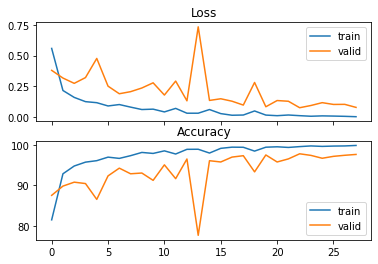

In [121]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(final_train_loss)
ax1.plot(final_valid_loss)
ax1.legend(['train', 'valid'])
ax1.set_title('Loss')

ax2.plot(final_train_acc)
ax2.plot(final_valid_acc)
ax2.legend(['train', 'valid'])
ax2.set_title('Accuracy')

## 4. Inference

In [139]:
best_model.eval()
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in test_loader:
    with torch.no_grad():
        images = images.to(device)
        scores = best_model(images)
        preds = scores.argmax(dim=-1)
        all_predictions.extend(preds.cpu().numpy())

In [140]:
len(all_predictions)

12600

In [141]:
from collections import Counter
Counter(all_predictions)

Counter({13: 549,
         1: 2601,
         12: 451,
         0: 2299,
         7: 602,
         3: 1556,
         4: 1845,
         6: 462,
         2: 417,
         5: 253,
         16: 353,
         14: 73,
         9: 302,
         11: 50,
         15: 308,
         10: 378,
         17: 47,
         8: 54})

In [142]:
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission_inceptionresnetv2_2.csv'), index=False)
print('test inference is done!')

test inference is done!
